In [1]:
# K√ºt√ºphaneler
import pandas as pd
import os
import glob
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import time
from scipy import stats 

In [2]:
# Bilgisayar i√ßin olan uyarƒ±larƒ± kapatma
os.environ["LOKY_MAX_CPU_COUNT"] = "10"  # Ger√ßek √ßekirdek sayƒ±nƒ± yaz

# Veri setini y√ºkleyin
df = pd.read_csv("kc_house_data.csv")

# Veri setinin boyutunu kontrol edin
print(f"Veri seti boyutu: {df.shape}")

# Eksik deƒüerleri kontrol edin
print(f"Eksik deƒüerler: {df.isnull().sum().sum()}")

Veri seti boyutu: (21613, 21)
Eksik deƒüerler: 0


In [3]:
# ----------------------------
# Veri √ñn ƒ∞≈üleme
# ----------------------------

# Date s√ºtununu datetime formatƒ±na d√∂n√º≈üt√ºrme
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day

# Ev ya≈üƒ± hesaplama
df['house_age'] = 2023 - df['yr_built']

# One-Hot Encoding (OHE) - zipcode i√ßin - √áok fazla s√ºtun olu≈üturduƒüu i√ßin blockladƒ±m 
# df = pd.get_dummies(df, columns=['zipcode'], drop_first=True)
    
# Fiyat kategorileri 
df['price_category'] = pd.cut(df['price'], 
                             bins=[0, 300000, 500000, 750000, float('inf')],
                             labels=['D√º≈ü√ºk', 'Orta', 'Y√ºksek', 'Premium'])

# Oda ba≈üƒ±na metrekare (0'a b√∂lme hatasƒ±nƒ± √∂nle)
df['sqft_per_room'] = df['sqft_living'] / (df['bedrooms'] + df['bathrooms'] + 1)

# Ya≈üam alanƒ± oranlarƒ±
df['living_lot_ratio'] = df['sqft_living'] / df['sqft_lot']
df['above_total_ratio'] = df['sqft_above'] / df['sqft_living']

# Yenilenme durumu
df['is_renovated'] = (df['yr_renovated'] > 0).astype(int)

# Waterfront ve view kombinasyonu
df['premium_location'] = ((df['waterfront'] == 1) | (df['view'] > 2)).astype(int)

# Ev b√ºy√ºkl√ºk kategorisi
df['house_size'] = pd.cut(df['sqft_living'], 
                         bins=[0, 1500, 2500, 4000, float('inf')],
                         labels=[1, 2, 3, 4])  
df['house_size'] = df['house_size'].astype(int)  

# Kat oranƒ±
df['floors_ratio'] = df['floors'] / df['sqft_living'] * 1000  # Normalize i√ßin

In [17]:
# 1. OUTLIER ANALƒ∞Zƒ∞
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] < lower_bound) | (df[column] > upper_bound)]

print("\n--- OUTLIER ANALƒ∞Zƒ∞ ---")
price_outliers = detect_outliers(df, 'price')
print(f"Fiyat outlier'larƒ±: {len(price_outliers)} adet")



--- OUTLIER ANALƒ∞Zƒ∞ ---
Fiyat outlier'larƒ±: 1146 adet


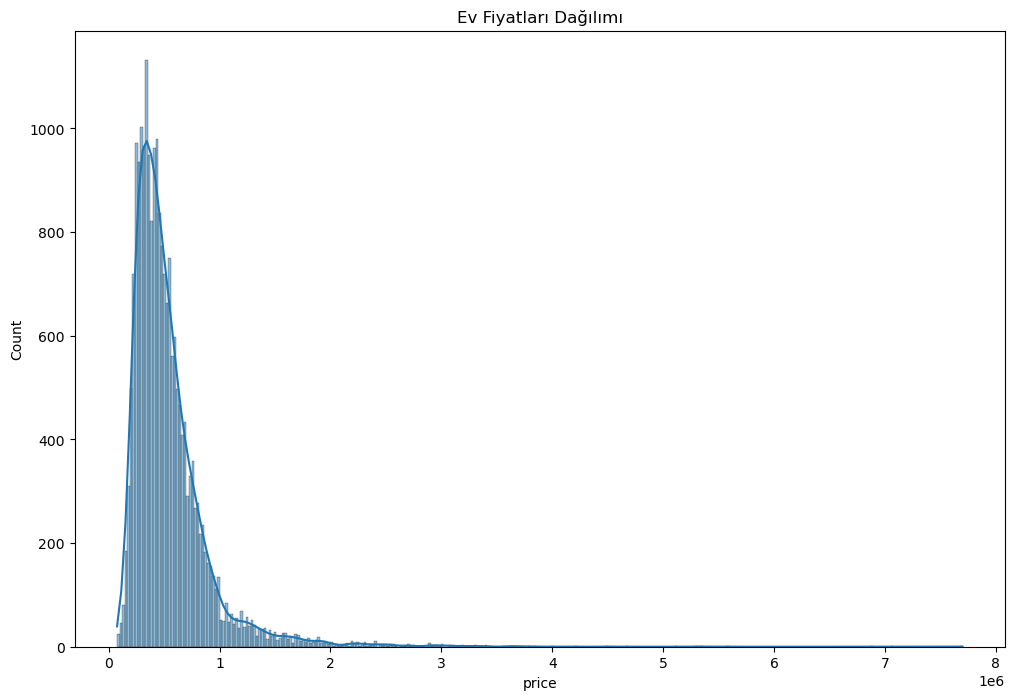

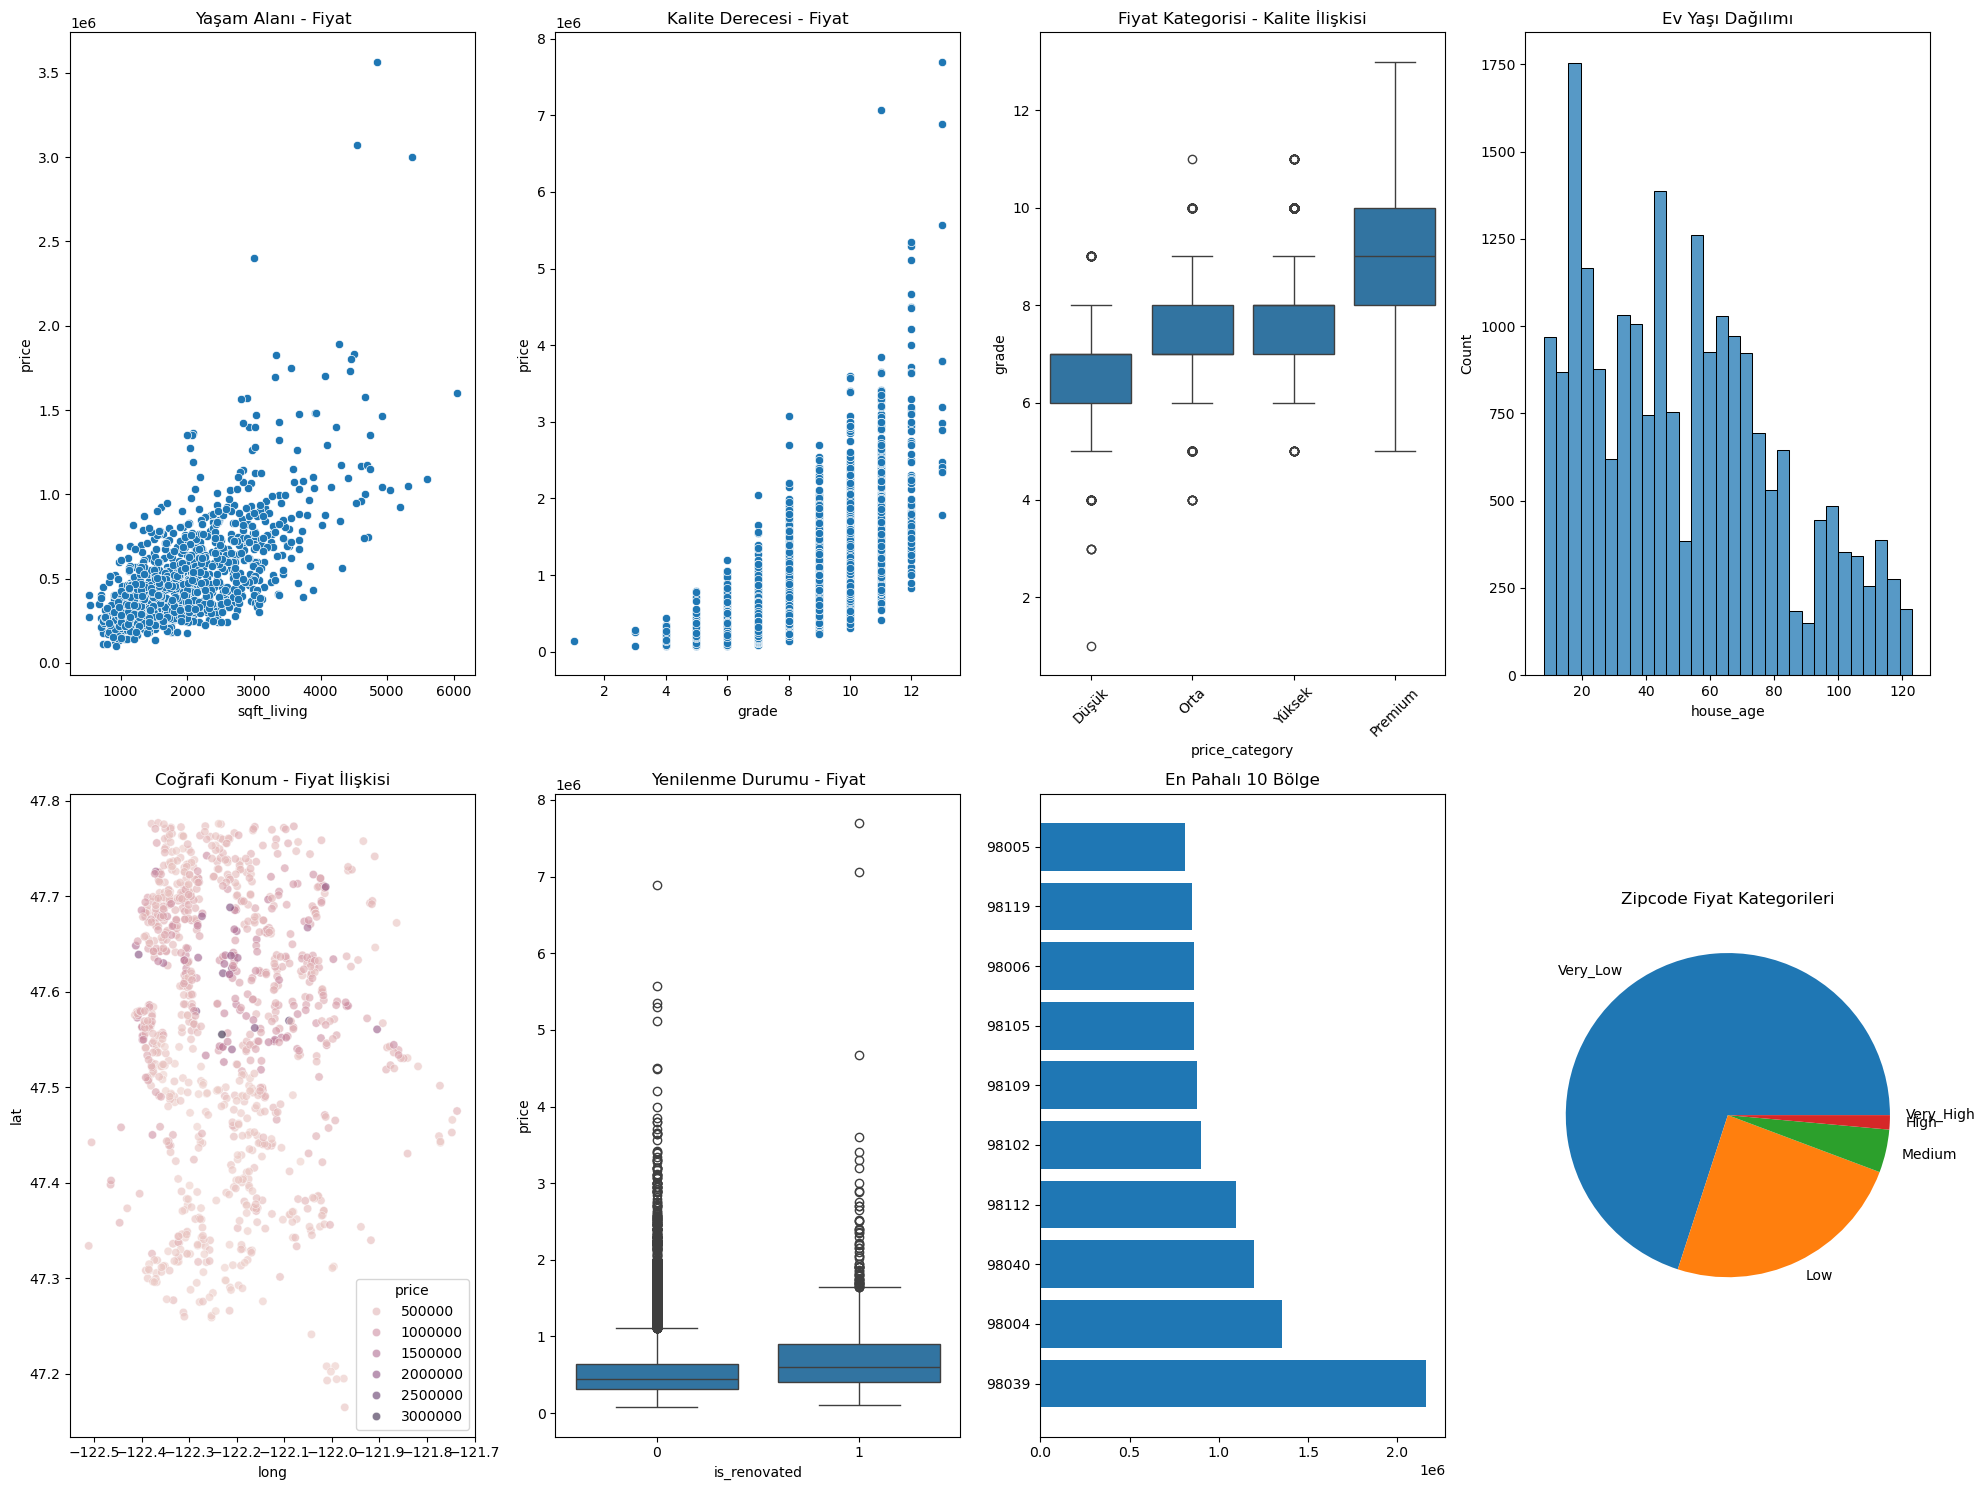

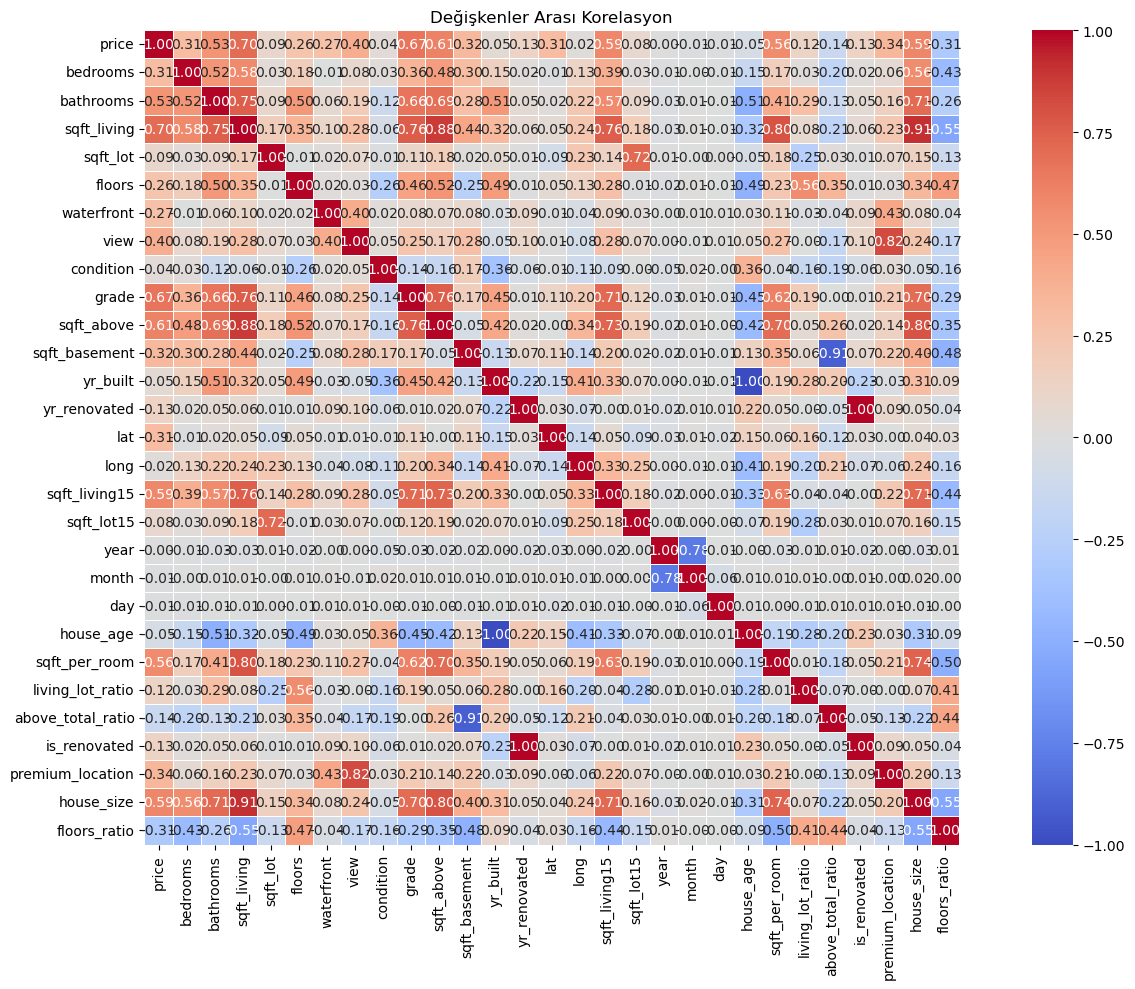


√ñzellik sayƒ±sƒ±: 28
Kullanƒ±lan √∂zellikler: ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15', 'year', 'month', 'day', 'house_age', 'sqft_per_room', 'living_lot_ratio', 'above_total_ratio', 'is_renovated', 'premium_location', 'house_size', 'floors_ratio']


In [5]:
# ----------------------------
# Veri G√∂rselle≈ütirme
# ----------------------------

# Ev Fiyatlarƒ± Daƒüƒ±lƒ±mƒ± (TEK BA≈ûINA)
plt.figure(figsize=(12, 8))
sns.histplot(df['price'], kde=True)
plt.title('Ev Fiyatlarƒ± Daƒüƒ±lƒ±mƒ±')
plt.show()

# Detaylƒ± G√∂rselle≈ütirmeler
plt.figure(figsize=(20, 15))

plt.subplot(2, 4, 1)
sns.scatterplot(x='sqft_living', y='price', data=df.sample(1000))
plt.title('Ya≈üam Alanƒ± - Fiyat')

plt.subplot(2, 4, 2)
sns.scatterplot(x='grade', y='price', data=df)
plt.title('Kalite Derecesi - Fiyat')

plt.subplot(2, 4, 3)
sns.boxplot(data=df, x='price_category', y='grade')
plt.title('Fiyat Kategorisi - Kalite ƒ∞li≈ükisi')
plt.xticks(rotation=45)

plt.subplot(2, 4, 4)
sns.histplot(df['house_age'], bins=30)
plt.title('Ev Ya≈üƒ± Daƒüƒ±lƒ±mƒ±')

plt.subplot(2, 4, 5)
sns.scatterplot(data=df.sample(1000), x='long', y='lat', hue='price', alpha=0.6)
plt.title('Coƒürafi Konum - Fiyat ƒ∞li≈ükisi')

plt.subplot(2, 4, 6)
sns.boxplot(data=df, y='price', x='is_renovated')
plt.title('Yenilenme Durumu - Fiyat')

plt.subplot(2, 4, 7)

# En pahalƒ± 10 zipcode
top_zipcodes = df.groupby('zipcode')['price'].mean().nlargest(10)
plt.barh(range(10), top_zipcodes.values)
plt.yticks(range(10), top_zipcodes.index)
plt.title('En Pahalƒ± 10 B√∂lge')

plt.subplot(2, 4, 8)

# Zipcode kategorilerinin daƒüƒ±lƒ±mƒ±
zipcode_cat_counts = df.groupby('zipcode')['price'].mean()
zipcode_cat_counts = pd.cut(zipcode_cat_counts, bins=5).value_counts()
plt.pie(zipcode_cat_counts.values, labels=['Very_Low', 'Low', 'Medium', 'High', 'Very_High'])
plt.title('Zipcode Fiyat Kategorileri')

plt.tight_layout()
plt.show()

# Korelasyon analizi (MEVCUT KODUN YERƒ∞NE)
plt.figure(figsize=(15, 10))
numeric_df = df.select_dtypes(include=[np.number])
# Kategorik s√ºtunlarƒ± √ßƒ±kar
numeric_df = numeric_df.drop(['id', 'zipcode'], axis=1, errors='ignore')
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, 
            fmt='.2f', square=True)
plt.title('Deƒüi≈ükenler Arasƒ± Korelasyon')
plt.tight_layout()
plt.show()

# ----------------------------
# Eƒüitim ve test verisine ayƒ±rma 
# ----------------------------

from sklearn.model_selection import train_test_split

# Gereksiz s√ºtunlarƒ± √ßƒ±kar
columns_to_drop = ['price', 'id', 'date', 'zipcode', 'price_category']  
X = df.drop(columns_to_drop, axis=1, errors='ignore')
y = df['price']

print(f"\n√ñzellik sayƒ±sƒ±: {X.shape[1]}")
print(f"Kullanƒ±lan √∂zellikler: {list(X.columns)}")

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Regresyon i√ßin Gerekli K√ºt√ºphaneler
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score

# √ñzellik √ñl√ßeklendirme
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modellerin Tanƒ±mlanmasƒ±
models = {
    'Doƒürusal Regresyon': LinearRegression(),
    'Ridge Regresyon': Ridge(alpha=1.0),
#    'Lasso Regresyon': Lasso(alpha=0.5, max_iter=10000),
    'ElasticNet': ElasticNet(alpha=1.0, max_iter=10000),
    'SVR': SVR(kernel='linear',C=1.0,epsilon=0.1),
    'KNN Regressor': KNeighborsRegressor(n_neighbors=5),
    'Karar Aƒüacƒ±': DecisionTreeRegressor(max_depth=10, random_state=42),
    'Rastgele Orman': RandomForestRegressor(n_estimators=100, random_state=42,n_jobs=-1),
    'Gradyan Arttƒ±rma': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Hangi modellerin √∂l√ßeklendirme gerektirdiƒüini belirle
scaled_models = {
    'Doƒürusal Regresyon',
    'Ridge Regresyon',
#    'Lasso Regresyon',
    'ElasticNet',
    'SVR',
    'KNN Regressor'
}

# Model performans kar≈üƒ±la≈ütƒ±rma i√ßin sonu√ßlar
results = {}

# Model Eƒüitimi ve Deƒüerlendirme
for name, model in models.items():
    print(f"{name} eƒüitiliyor...")
    start_time = time.time()
    
    if name in scaled_models:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2', n_jobs=-1)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2', n_jobs=-1)

    # Performans hesaplama
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    cv_r2_mean = cv_scores.mean()
    cv_r2_std = cv_scores.std()

    results[name] = {
        'MAE': mae,
        'MSE': mse,
        'RMSE': rmse,
        'R2': r2,
        'CV R2 (Ortalama)': cv_r2_mean,
        'CV R2 (Std Sapma)': cv_r2_std
    }

    end_time = time.time()
    train_time = end_time - start_time
    results[name]['Eƒüitim S√ºresi (s)'] = train_time

    print(f"{name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}, "
          f"R2: {r2:.4f}, CV R2: {cv_r2_mean:.4f} (+/- {cv_r2_std:.4f}), "
          f"Eƒüitim S√ºresi: {train_time:.2f} sn\n")

# En iyi modeli R2 skoruna g√∂re se√ß
best_model_name = max(results, key=lambda x: results[x]['R2'])
second_best_name = sorted(results.items(), key=lambda x: x[1]['R2'], reverse=True)[1][0]
print(f"\nüöÄ En iyi model: {best_model_name} (R2: {results[best_model_name]['R2']:.4f})")
# ƒ∞lerdeki kar≈üƒ±la≈ütƒ±rma tablosu i√ßin 
previous_metrics = results[best_model_name]


Doƒürusal Regresyon eƒüitiliyor...
Doƒürusal Regresyon - MAE: 125793.68, MSE: 44021898571.05, RMSE: 209813.96, R2: 0.7088, CV R2: 0.7013 (+/- 0.0363), Eƒüitim S√ºresi: 1.78 sn

Ridge Regresyon eƒüitiliyor...
Ridge Regresyon - MAE: 126124.11, MSE: 44236574637.60, RMSE: 210324.93, R2: 0.7074, CV R2: 0.7009 (+/- 0.0357), Eƒüitim S√ºresi: 1.40 sn

ElasticNet eƒüitiliyor...
ElasticNet - MAE: 131456.84, MSE: 56099215028.01, RMSE: 236852.73, R2: 0.6289, CV R2: 0.6382 (+/- 0.0228), Eƒüitim S√ºresi: 0.24 sn

SVR eƒüitiliyor...
SVR - MAE: 206197.29, MSE: 136249689434.18, RMSE: 369120.16, R2: 0.0987, CV R2: 0.0839 (+/- 0.0091), Eƒüitim S√ºresi: 14.29 sn

KNN Regressor eƒüitiliyor...
KNN Regressor - MAE: 111787.50, MSE: 44018515822.34, RMSE: 209805.90, R2: 0.7088, CV R2: 0.7198 (+/- 0.0299), Eƒüitim S√ºresi: 0.66 sn

Karar Aƒüacƒ± eƒüitiliyor...
Karar Aƒüacƒ± - MAE: 97450.28, MSE: 41816299297.52, RMSE: 204490.34, R2: 0.7234, CV R2: 0.7566 (+/- 0.0418), Eƒüitim S√ºresi: 0.56 sn

Rastgele Orman eƒüi


üöÄ En iyi model: Rastgele Orman (R2: 0.8463)
ü•à ƒ∞kinci en iyi: Gradyan Arttƒ±rma (R2: 0.8459)
   ‚Ä¢ Rastgele Orman: Daha √ßok optimize ederken k√∂t√ºle≈ütiriyor
   ‚Ä¢ Gradyan: Arttƒ±rma: Optimize ederken iyile≈ütiriyor 
üí° : Bu Y√ºzden ben Gradyan Arttƒ±rma ile devam ediyorum.
RandomizedSearchCV ba≈ülatƒ±lƒ±yor...
Fitting 3 folds for each of 25 candidates, totalling 75 fits

En iyi parametreler: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 5, 'learning_rate': 0.1}
En iyi negatif MSE skoru: -14933387423.247282
En iyi RMSE: 122202.24

Optimize edilmi≈ü Gradyan Artƒ±rma - MAE: 75272.06, RMSE: 139530.47, R2: 0.8712

=== KAR≈ûILA≈ûTIRMA TABLOSU ===
                       √ñnceki Model  Optimize Edilmi≈ü Model  ƒ∞yile≈üme (%)
MAE                       74,420.93               75,272.06         -1.14
MSE               23,235,745,448.42       19,468,753,376.70         16.21
RMSE                     152,432.

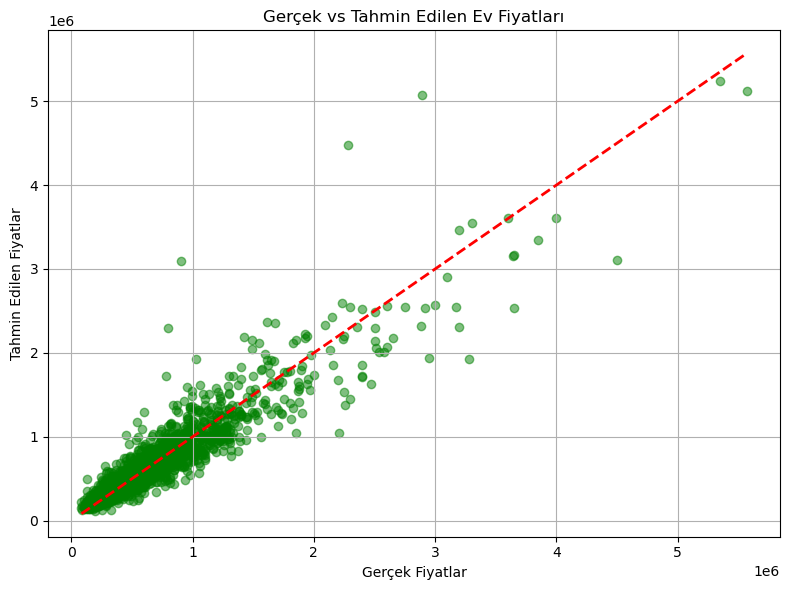

In [7]:
# Hiperparametre Optimizasyonu
# En Ba≈üta Yaptƒ±ƒüƒ±mda Gradyan Arttƒ±rma √ßƒ±ktƒ± sonra √∂ni≈ülemeyi detaylandƒ±rƒ±nca rastgele orman √ßƒ±ktƒ±ƒüƒ± i√ßin iki if ile ele aldƒ±m .
from sklearn.model_selection import RandomizedSearchCV
print(f"\nüöÄ En iyi model: {best_model_name} (R2: {results[best_model_name]['R2']:.4f})")
print(f"ü•à ƒ∞kinci en iyi: {second_best_name} (R2: {results[second_best_name]['R2']:.4f})")
print(f"   ‚Ä¢ Rastgele Orman: Daha √ßok optimize ederken k√∂t√ºle≈ütiriyor")
print(f"   ‚Ä¢ Gradyan: Arttƒ±rma: Optimize ederken iyile≈ütiriyor ")
print(f"üí° : Bu Y√ºzden ben Gradyan Arttƒ±rma ile devam ediyorum.")
# En iyi modeli gradyan arttƒ±rma olarak deƒüi≈ütir 
best_model_name="Gradyan Arttƒ±rma"
# En iyi modelin Hiperparametrelerini optimize etme
if best_model_name == "Gradyan Arttƒ±rma":
    # Uzayƒ±nƒ± tanƒ±mlama
    param_dist = {
        'n_estimators': [50, 100, 150, 200, 300],
        'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
        'max_depth': [3, 4, 5, 6, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'subsample': [0.8, 0.9, 1.0],
        'max_features': ['sqrt', 'log2']
    }
    # RandomizedSearchCV nesnesi olu≈üturun
    random_search = RandomizedSearchCV(
        estimator=GradientBoostingRegressor(random_state=42),
        param_distributions=param_dist,
        n_iter=25,  # 25 farklƒ± kombinasyon deneyin (bu sayƒ±yƒ± deƒüi≈ütirebilirsiniz)
        cv=3,       # 3-katlƒ± √ßapraz doƒürulama
        scoring='neg_mean_squared_error',
        n_jobs=-1,  # T√ºm CPU √ßekirdeklerini kullanƒ±r
        random_state=42,
        verbose=1   # ƒ∞lerleme durumunu g√∂sterir
    )

    # Eƒüitimi ba≈ülatƒ±n
    print("RandomizedSearchCV ba≈ülatƒ±lƒ±yor...")
    start_time = time.time()
    random_search.fit(X_train_scaled, y_train)
    training_duration = time.time() - start_time

    # En iyi parametreleri ve skoru g√∂r√ºnt√ºleyin
    print("\nEn iyi parametreler:", random_search.best_params_)
    print("En iyi negatif MSE skoru:", random_search.best_score_)
    best_rmse = np.sqrt(-random_search.best_score_)
    print(f"En iyi RMSE: {best_rmse:.2f}")

    # En iyi modeli alƒ±p test setinde deƒüerlendirin
    best_model = random_search.best_estimator_
    y_pred_best = best_model.predict(X_test_scaled)

    # Final sonu√ßlarƒ±nƒ± hesaplayƒ±n
    mae_best = mean_absolute_error(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    cv_r2_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=3, scoring='r2')
    cv_r2_mean = np.mean(cv_r2_scores)
    cv_r2_std = np.std(cv_r2_scores)
    optimized_metrics = {
    'MAE': mae_best,
    'MSE': mse_best,
    'RMSE': rmse_best,
    'R2': r2_best,
    'CV R2 (Ortalama)': cv_r2_mean,
    'CV R2 (Std Sapma)': cv_r2_std,
    'Eƒüitim S√ºresi (s)': training_duration
    }
    print(f"\nOptimize edilmi≈ü Gradyan Artƒ±rma - MAE: {mae_best:.2f}, RMSE: {rmse_best:.2f}, R2: {r2_best:.4f}")
    #Tablo Olu≈üturup yazma 
    print("\n=== KAR≈ûILA≈ûTIRMA TABLOSU ===")

    df_compare = pd.DataFrame({
        '√ñnceki Model': previous_metrics,
        'Optimize Edilmi≈ü Model': optimized_metrics
    })

    df_compare['ƒ∞yile≈üme (%)'] = ((df_compare['Optimize Edilmi≈ü Model'] - df_compare['√ñnceki Model']) / df_compare['√ñnceki Model']) * 100

    for metric in ['MAE', 'MSE', 'RMSE']:
        df_compare.loc[metric, 'ƒ∞yile≈üme (%)'] *= -1
    pd.set_option('display.float_format', '{:,.2f}'.format)  
    # Display yerine print kullan
    print(df_compare.round(2))
    
    # Tahminin Ba≈üarƒ± Grafiƒüi (D√úZELTME: y_pred_best kullan)
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.5, color='green')  # y_pred_best kullan
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel("Ger√ßek Fiyatlar")
    plt.ylabel("Tahmin Edilen Fiyatlar")
    plt.title("Ger√ßek vs Tahmin Edilen Ev Fiyatlarƒ±")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

elif best_model_name == "Rastgele Orman":
    # Uzayƒ±nƒ± tanƒ±mlama
    param_dist = {
        'n_estimators': [100, 200, 300,],
        'max_depth': [10, 15, 20, 25,50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2'],
        'bootstrap': [True, False]
    }
    random_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1),  # DOƒûRU estimator
        param_distributions=param_dist,
        n_iter=50,
        cv=3,
        scoring='r2', 
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    # Eƒüitimi ba≈ülatƒ±n
    print("RandomizedSearchCV ba≈ülatƒ±lƒ±yor...")
    random_search.fit(X_train, y_train)

    # En iyi parametreleri ve skoru g√∂r√ºnt√ºleyin
    print("\nEn iyi parametreler:", random_search.best_params_)
    print("En iyi R2 skoru:", random_search.best_score_)

    # En iyi modeli alƒ±p test setinde deƒüerlendirin
    best_model = random_search.best_estimator_
    y_pred_best = best_model.predict(X_test)

    # Final sonu√ßlarƒ±nƒ± hesaplayƒ±n
    mae_best = mean_absolute_error(y_test, y_pred_best)
    mse_best = mean_squared_error(y_test, y_pred_best)
    rmse_best = np.sqrt(mse_best)
    r2_best = r2_score(y_test, y_pred_best)
    optimized_metrics = {
    'MAE': mae_best,
    'MSE': mse_best,
    'RMSE': rmse_best,
    'R2': r2_best
    }
    print(f"\nOptimize edilmi≈ü Rastgele Orman - MAE: {mae_best:.2f}, RMSE: {rmse_best:.2f}, R2: {r2_best:.4f}")
    #Tablo Olu≈üturup yazma 
    print("\n=== KAR≈ûILA≈ûTIRMA TABLOSU ===")

    df_compare = pd.DataFrame({ 
        '√ñnceki Model': previous_metrics,
        'Optimize Edilmi≈ü Model': optimized_metrics
    })

    df_compare['ƒ∞yile≈üme (%)'] = ((df_compare['Optimize Edilmi≈ü Model'] - df_compare['√ñnceki Model']) / df_compare['√ñnceki Model']) * 100

    for metric in ['MAE', 'MSE', 'RMSE']:
        df_compare.loc[metric, 'ƒ∞yile≈üme (%)'] *= -1

    # Display yerine print kullan
    print(df_compare.round(2))
    
    # Tahminin Ba≈üarƒ± Grafiƒüi
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred_best, alpha=0.5, color='green')  
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
    plt.xlabel("Ger√ßek Fiyatlar")
    plt.ylabel("Tahmin Edilen Fiyatlar")
    plt.title("Ger√ßek vs Tahmin Edilen Ev Fiyatlarƒ±")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [8]:
def predict_house_price(sqft_living, bedrooms, bathrooms, grade, year_built):
    """Ger√ßek hayat senaryosu i√ßin tahmin fonksiyonu"""
    
    sample_data = pd.DataFrame({
        'bedrooms': [bedrooms],
        'bathrooms': [bathrooms], 
        'sqft_living': [sqft_living],
        'sqft_lot': [7500],
        'floors': [1.0],
        'waterfront': [0],
        'view': [0],
        'condition': [3],
        'grade': [grade],
        'sqft_above': [int(sqft_living * 0.8)],
        'sqft_basement': [int(sqft_living * 0.2)],
        'yr_built': [year_built],
        'yr_renovated': [0],
        'lat': [47.5],
        'long': [-122.3],
        'sqft_living15': [sqft_living],
        'sqft_lot15': [7500],
        'year': [2023],
        'month': [5],
        'day': [15],
        'house_age': [2023 - year_built],
        'sqft_per_room': [sqft_living / (bedrooms + bathrooms + 1)],
        'living_lot_ratio': [sqft_living / 7500],
        'above_total_ratio': [0.8],
        'is_renovated': [0],
        'premium_location': [0],
        'house_size': [2 if sqft_living < 2500 else 3],
        'floors_ratio': [1.0 / sqft_living * 1000]
    })
    
    # Model tipine g√∂re tahmin
    if best_model_name == "Gradyan Arttƒ±rma":
        sample_scaled = scaler.transform(sample_data)
        prediction = best_model.predict(sample_scaled)
    else:  # Random Forest
        prediction = best_model.predict(sample_data)
    
    return prediction[0]


üè† √ñRNEK EV TAHMƒ∞NLERƒ∞:
K√º√ß√ºk ev: $268,643
Orta ev: $387,369
B√ºy√ºk ev: $732,896
L√ºks ev: $2,025,636

--- √ñZELLƒ∞K √ñNEMƒ∞ ANALƒ∞Zƒ∞ ---


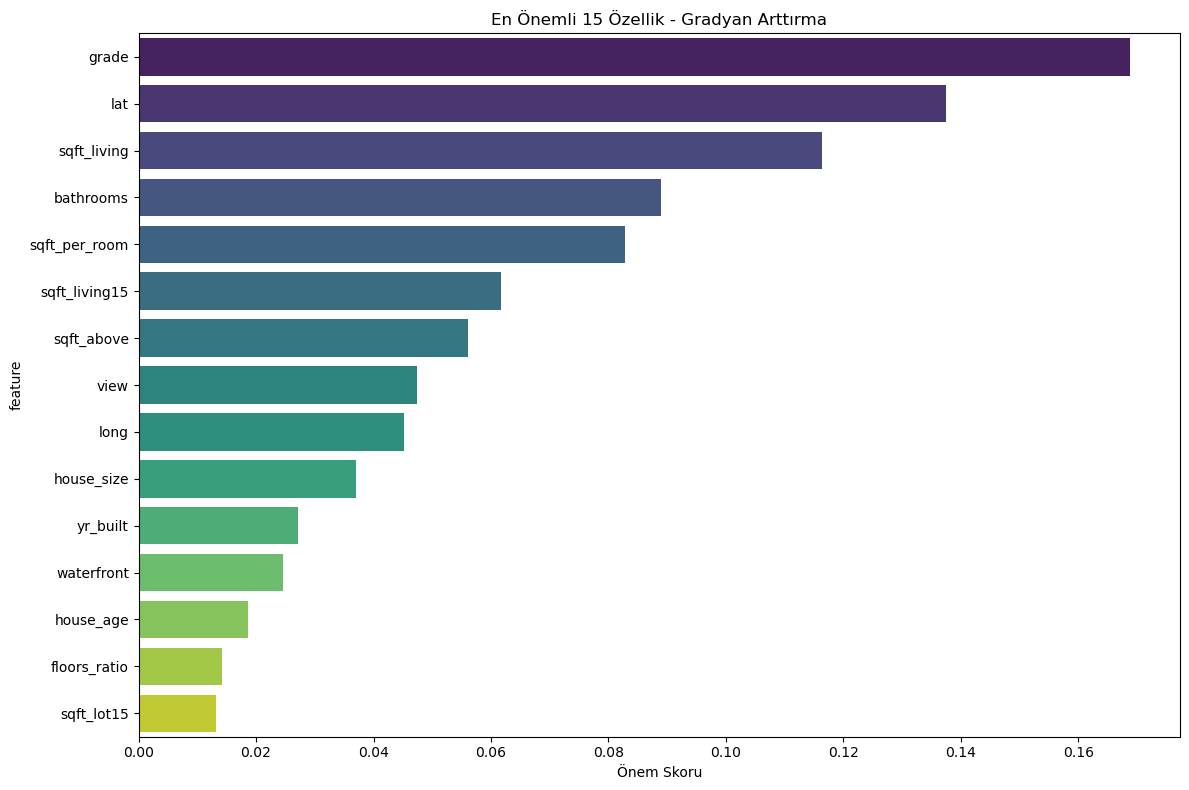


En √∂nemli √∂zellikler (Gradyan Arttƒ±rma):
grade               : 0.1689
lat                 : 0.1376
sqft_living         : 0.1164
bathrooms           : 0.0890
sqft_per_room       : 0.0829
sqft_living15       : 0.0618
sqft_above          : 0.0561
view                : 0.0474
long                : 0.0453
house_size          : 0.0370

--- PERFORMANS ANALƒ∞Zƒ∞ ---


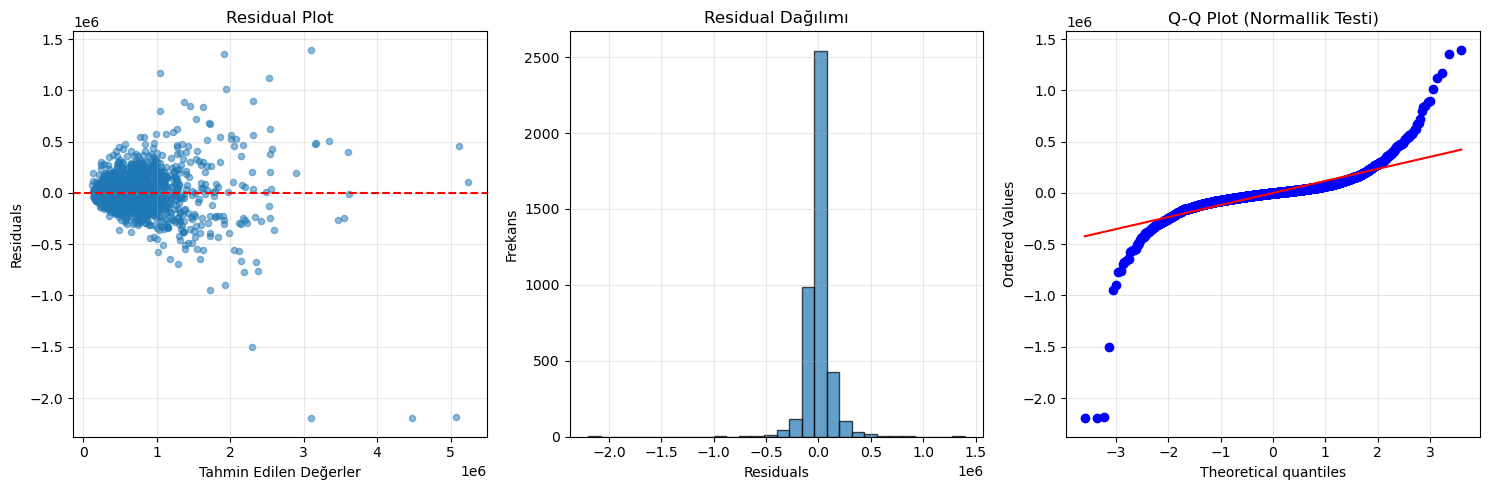

In [9]:
# √ñrnek kullanƒ±m
print("\nüè† √ñRNEK EV TAHMƒ∞NLERƒ∞:")

test_cases = [
    (1500, 2, 1, 6, 2000, "K√º√ß√ºk ev"),
    (2000, 3, 2, 8, 1990, "Orta ev"),
    (3500, 4, 3, 10, 2010, "B√ºy√ºk ev"),
    (5000, 5, 4, 12, 2015, "L√ºks ev")
]

for sqft, bed, bath, grade, year, desc in test_cases:
    try:
        price = predict_house_price(sqft, bed, bath, grade, year)
        print(f"{desc}: ${price:,.0f}")
    except Exception as e:
        print(f"{desc}: Tahmin hatasƒ± - {e}")

# FEATURE IMPORTANCE
print("\n--- √ñZELLƒ∞K √ñNEMƒ∞ ANALƒ∞Zƒ∞ ---")

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': best_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance',hue='feature' , y='feature', palette='viridis')
plt.title(f'En √ñnemli 15 √ñzellik - {best_model_name}')
plt.xlabel('√ñnem Skoru')
plt.tight_layout()
plt.show()

print(f"\nEn √∂nemli √∂zellikler ({best_model_name}):")
for i, row in feature_importance.head(10).iterrows():
    print(f"{row['feature']:20}: {row['importance']:.4f}")

# MODEL PERFORMANS Vƒ∞Z√úALƒ∞ZASYONU
print("\n--- PERFORMANS ANALƒ∞Zƒ∞ ---")

residuals = y_test - y_pred_best
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(y_pred_best, residuals, alpha=0.5, s=20)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Tahmin Edilen Deƒüerler')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.hist(residuals, bins=30, alpha=0.7, edgecolor='black')
plt.xlabel('Residuals')
plt.ylabel('Frekans')
plt.title('Residual Daƒüƒ±lƒ±mƒ±')
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Normallik Testi)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()